In [3]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway


In [4]:
sales = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/train.csv')
store = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/store.csv')
future_sales = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/test.csv')
sales['StateHoliday'] = sales['StateHoliday'].replace({0:"0"})
sales['StateHoliday'] = sales['StateHoliday'].replace({'0':'d'})

D:\ANACONDA1\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
def processing_data(sales,store) :
    sales['Date'] = pd.to_datetime(sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
    sales['StateHoliday'] = sales['StateHoliday'].replace({0:"0"})
    sales['StateHoliday'] = sales['StateHoliday'].replace({'0':'d'})
    sales = sales.sort_values('Date')
    
    one_hot = []
    for i in range(0,len(sales)) :
        one_hot.append(0)
        
    name = ['StateHoliday_a','StateHoliday_b','StateHoliday_c','StateHoliday_d']
    values = ['a','b','c','d']
    counts = sales['StateHoliday'].value_counts().sort_index().index

    for i in range(0,len(values)) :
        if values[i] not in counts :
            sales[name[i]] = one_hot        
    sales = pd.get_dummies(data = sales, columns = ['StateHoliday'])
    columns = sales.columns.tolist()
    columns.sort()
    sales = sales[columns]
    
    store = processing_store(store)
    store_copy = store
    store_copy= pd.merge(left=sales,right=store_copy,on='Store')

    store_copy['Year']=pd.DatetimeIndex(store_copy.Date).year
    store_copy['Month']=pd.DatetimeIndex(store_copy.Date).month
    store_copy['Day']=pd.DatetimeIndex(store_copy.Date).day
    if 'Id' in sales :
        store_copy = store_copy.drop(['Date','Store','Id'],axis=1)
    else :
        store_copy = store_copy.drop(['Date','Store','Customers'],axis=1)
        

    
    return make_regression_model_1(store_copy)

def processing_store(store) :
    store_copy = store.copy()
    store_copy['CompetitionDistance'] = store_copy['CompetitionDistance'].fillna(
        store_copy['CompetitionDistance'].mean())

    store_copy_cols = ['CompetitionOpenSinceYear','CompetitionOpenSinceMonth',
                    'Promo2SinceWeek','Promo2SinceYear','PromoInterval']
    for i in store_copy_cols :
        store_copy[i].fillna(0,inplace=True)
    store_copy = pd.get_dummies(data=store_copy,columns=['Assortment','PromoInterval','StoreType'])
    return store_copy

def make_regression_model_1(train_data) :
    target_col = 'Sales'
    input_cols = train_data.columns.drop(target_col)
    train_x,test_x,train_y,test_y = train_test_split(train_data[input_cols],
                                                    train_data[target_col],
                                                    test_size=0.4,random_state=1)
    
    test_x,val_x,test_y,val_y = train_test_split(test_x[input_cols],
                                                test_y,
                                                test_size=0.5)
    
    return train_x,test_x,val_x,train_y,test_y,val_y



In [66]:
train_x,test_x,val_x,train_y,test_y,val_y=processing_data(sales,store)
# train_data =processing_data(sales,store)
# pred_data = processing_data(future_sales,store)
train_x2 = pd.concat([train_x,val_x])
train_y2 = pd.concat([train_y,val_y])

In [67]:
model = XGBRegressor(tree_method='gpu_hist',gpu_id ='0',predictor ='gpu_predictor',
                    n_estimators =400,max_depth = 12, learning_rate = 0.05)
# fit_params = dict(
#         eval_set=[(val_x, val_y)], 
#         early_stopping_rounds=10
#         )
model.fit(train_x2,train_y2)
filename = 'xgb_model.model'
model.save_model(filename)

In [84]:
pred= model.predict(test_x)

In [85]:
mse = mean_squared_error(pred, test_y, squared=False)
print(mse)

710.5269301722333


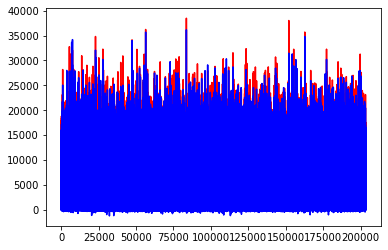

In [87]:
plt.plot(np.arange(1,len(test_y)+1),test_y,'r')
plt.plot(np.arange(1,len(test_y)+1),pred,'b')

(array([5.3050e+04, 9.6339e+04, 4.1338e+04, 9.1200e+03, 2.5010e+03,
        7.8200e+02, 2.1700e+02, 7.5000e+01, 1.5000e+01, 5.0000e+00]),
 array([    0. ,  3848.4,  7696.8, 11545.2, 15393.6, 19242. , 23090.4,
        26938.8, 30787.2, 34635.6, 38484. ]),
 <BarContainer object of 10 artists>)

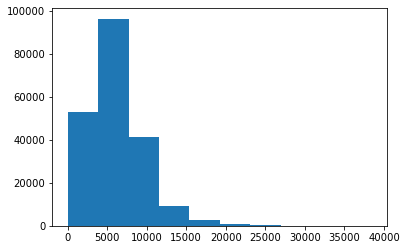

In [88]:
plt.hist(test_y)

(array([3.6778e+04, 7.6011e+04, 6.9128e+04, 1.6435e+04, 3.5380e+03,
        1.1860e+03, 2.7100e+02, 7.5000e+01, 1.4000e+01, 6.0000e+00]),
 array([-1274.0756,  2468.5938,  6211.263 ,  9953.933 , 13696.602 ,
        17439.271 , 21181.94  , 24924.61  , 28667.28  , 32409.947 ,
        36152.617 ], dtype=float32),
 <BarContainer object of 10 artists>)

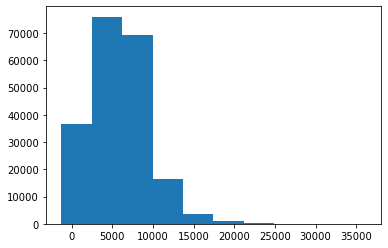

In [89]:
plt.hist(pred)

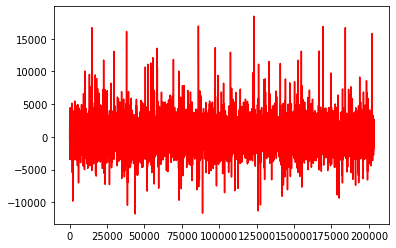

In [91]:
error_xgboost = test_y - pred
plt.plot(np.arange(1,len(test_y)+1),error_xgboost,'r')